# Project Directory

For all the below arrangements to work properly, project should have the directory as below:
Initial folder "/data/full_faces/non_occlueded/data.csv" has a specific name structure that every individual person has a unique name or id followed by a at least two digit numeral like 'adrian01.jpg' or '000005.jpg'

In [ ]:
"""
Project
|--data
    |--full_faces
        |--non_occluded
            |--images
            |--data_map.cvs
        |--occluded
            |--images
            |--data_map.csv
    |--facial_parts
        |--non_occluded
            |--images
            |--data_map.csv
        |--occluded
            |--images
            |--data.cvs
|--model
    |--dlib_landmar
    |--resnet
"""

#Introduction

In this notebook, we obtain and preprocess the data in order to perform facial recognition action. After we detect the faces and landmarks, we will save them into three folders; being the templates (train), test and validation as probe images. In this step, it is important not to put any same image in the templates, test and validation folders for it would harm the test results. Probe images will be artificially occluded while template images kept clean.

 All of the face images are located in the '/data/images' folder. This data's been collected from [here](http://pics.stir.ac.uk/2D_face_sets.htm) and its introduced in Kumar and Shanmugavadivu's (2018) paper. You can find the paper [here](https://www.sciencepubco.com/index.php/ijet/article/view/11804/4597). The Dataset consists of a total of 687 color face pictures belonging to 90 different people. Pictures can be in different facial expressions and sizes. Some of the naming of the image files has been changed in order to use them optimally. For this reason, it is recommended to use the files in the data folder.

This project works on Google Drive with Google Colab Notebook. So we first mount on drive folder to use the data in the notebook. Below code will create an auth key to copy-paste and mount drive account.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Then we import necessary libraries and use this IPython magic command '%cd' to locate project file. This will make assigning the paths much easier.

In [2]:
import os
import re
import cv2
import glob
import dlib
import random
import numpy as np
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display

from google.colab.patches import cv2_imshow #this will make viewing images in Colab notebook possible since 'cv2.imshow()' is not supported in Colab notebooks.

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
%matplotlib inline 

%cd /content/drive/My Drive/IYTE/CENG 507 (Introduction to Biometric Recognition)/Project

/content/drive/My Drive/IYTE/CENG 507 (Introduction to Biometric Recognition)/Project


#Model Setup

As first step, we define two models for face and landmark detection.

**Face detection:** OpenCV's pretrained Caffe model that uses single shot multibox detector model based on [paper](https://arxiv.org/pdf/1512.02325.pdf) by Liu et al. (2016) and uses ResNet architechture presented in He et al. (2015) [paper](https://arxiv.org/pdf/1512.03385.pdf). Model consist of 32 Convolutional layers, (some with pooling and batch normalization) uses ReLU as activation function and softmax for the output. Original model obtained from [this](https://github.com/spmallick/learnopencv/blob/master/FaceDetectionComparison/models/res10_300x300_ssd_iter_140000_fp16.caffemodel) Github repo of Satya Mallick. For this project it is located in '/model/resnet' folder.

**Landmark Detection:** Dlib's learning based pretrained model for 68 point landmark detection trained with ibug 300-W [dataset](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/) and originally located in Dlib Github [repo](https://github.com/davisking/dlib-models) of Davis E. King. For this project it is located in '/model/dlib-landmark' folder.

In [3]:
model_file = "./model/resnet/res10_300x300_ssd_iter_140000_fp16.caffemodel"
config_file = "./model/resnet/deploy.prototxt"
model = cv2.dnn.readNetFromCaffe(config_file, model_file)

landmark_detector = dlib.shape_predictor("./model/dlib_landmark/shape_predictor_68_face_landmarks.dat")

##Face Detector

We will initilize a face detector function. This funcrion takes an cv2 image as input and returns detected face and bounding rectangle coordinates of that face inside input image. Function returns a grayscaled image (instead of RGB or BGR) since the recognition model accepts single channel as input.

In [4]:
def get_face(img):
  (h, w) = img.shape[:2] #gets the height and width of the image
  resized_img = cv2.resize(img, (300, 300)) #We will resize the image to 300x300 since its our models defined input size.
  blob = cv2.dnn.blobFromImage(resized_img, 1.0, (300, 300), (104, 117, 123), swapRB=False) #We don't use scaling so the scale factor is 1.0. (104, 117, 123) are the defined mean pixel values for our model.
  model.setInput(blob) #We set the blobs (attention regions) as input
  detections = model.forward() #and let the model make detections. It will create multiple detections but we only need one.
  for detection in detections[0][0][:5]: #For the first 5 detections, we will turn it into a box. If there is not suitable area in first 5 detections, we assume no face has been detected.
    box = detection[3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    if(startX < w and startY < h and endX < w and endY < h): #if detected region is fully inside the image
        return cv2.cvtColor(img[startY:endY, startX:endX], cv2.COLOR_BGR2GRAY), dlib.rectangle(startX, startY, endX, endY) 
#we return the first suitable coordinates as an image(grayscaled) and a dlib rectangle since we assume the image has only one face in it.

#Prepearing Data Partitions




In [ ]:
data = pd.DataFrame([os.path.basename(file) for file in glob.glob("./data/full_faces/non_occluded/images/*.jpg")], columns=["file"])

data = data.sort_values(by="file", ignore_index=True)
data["identity"] = data["file"].apply(lambda x: re.sub("[0-9]","",x[:-4]) if re.match('[a-z]', x[:-4]) else x[:-4])
data["image_no"] = data["file"].apply(lambda x: re.sub("_|[a-z]","",x[:-4]) if re.match('[a-z]', x[:-4]) else "01")
data["image_count"] = data["identity"].apply(lambda x: data[data.identity == x].shape[0])

#numerification of the identities
id_dict = { name: i for i, name in enumerate(data["identity"].unique())}
data["identity"] = data["identity"].apply(lambda x: id_dict[x])

data["partition"] = ""
alter = 0
alter2 = 0
for i in range(len(data["identity"].unique())): #for every identity
  if list(data.loc[data.identity == i, "image_count"])[0] == 1:#if image count is 1, goes test or validation alternating
    data.loc[data.identity == i, "partition"] = "validation" if alter % 2 == 0 else "test"
    alter +=1
  else:
    data.loc[(data.identity == i) & (data.image_no == "01"), "partition"] = "gallery"
    data.loc[(data.identity == i) & (data.image_no != "01"), "partition"] = "test" if alter2 % 2 == 0 else "validation"
    alter2 += 1

data[["file", "identity", "partition"]].to_csv("./data/full_faces/data_map.csv", index=None)

In [5]:
data = pd.read_csv("./data/full_faces/data_map_face_parts.csv")

#Full Face Identification

##Non-Occluded Images

In [6]:
def get_partititon(df, partititon):
  df = np.array([[get_face(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))[0], row.identity] for i, row in df[df.partition == partititon].iterrows()]).T
  return list(df[0]), np.array(list(df[1]))

In [7]:
gallery_images, gallery_labels = get_partititon(data, "gallery")

val_images, val_labels = get_partititon(data, "validation")

test_images, test_labels = get_partititon(data, "test")

In [29]:
def eval(images, labels, radius, neighbors, grid_x, grid_y, threshold):
  recognizer = cv2.face.LBPHFaceRecognizer_create(radius = radius, neighbors = neighbors, grid_x= grid_x, grid_y = grid_y)
  recognizer.train(gallery_images, gallery_labels)
  result = pd.DataFrame(columns=["occ_type", "correct_label", "prediction", "distance", "error"])

  for i, img in enumerate(images):

    prediction , distance = recognizer.predict(img)

    correct_label = labels[i] if labels[i] in gallery_labels else "unknown"

    prediction = prediction if distance <  threshold else "unknown"

    error = 0 if prediction == correct_label else 1

    occ_type = "mask" if i < 308 else "eyeglasses"

    result.loc[i] = [occ_type, correct_label,  prediction, distance, error]

  FAR = round(result[(result.correct_label == "unknown") & (result.error == 1)].shape[0] / result[result.correct_label == "unknown"].shape[0], 2)
  FRR = round(result[(result.correct_label != "unknown") & (result.error == 1)].shape[0] / result[result.correct_label != "unknown"].shape[0], 2)
  OE  = round(result[result.error == 1].shape[0] / result.shape[0], 2)
  #return FAR, FRR, OE
  return result

In [12]:
def random_search(images, labels, count):
  search_result = pd.DataFrame(columns=["params","FAR","FRR","OE"])
  bar = IntProgress(min=0, max=count)
  display(bar)
  for i in range(0,count):
    radius = random.randint(1,16)
    neighbors = random.randint(1,12)
    grid_x = random.randint(1,16)
    grid_y = random.randint(1,16)
    treshold = random.randint(10,30)
    FAR, FRR, OE = eval(images, labels, radius, neighbors, grid_x, grid_y, treshold)
    search_result.loc[i] = ["r:{}, n:{}, x:{}, y:{}, t:{}".format(radius, neighbors, grid_x, grid_y, treshold), FAR, FRR, OE]
    bar.value += 1
  return search_result

In [ ]:
def threshold_search(images, labels, values, params):
  result = pd.DataFrame(columns=["value","FAR","FRR","OE"])
  bar = IntProgress(min=0, max=len(values))
  display(bar)
  for i, t in enumerate(values):
    FAR, FRR, OE = eval(images, labels, params[0], params[1], params[2], params[3], t)
    result.loc[i] = [t, FAR, FRR, OE]
    bar.value += 1
  return result

IntProgress(value=0, max=50)

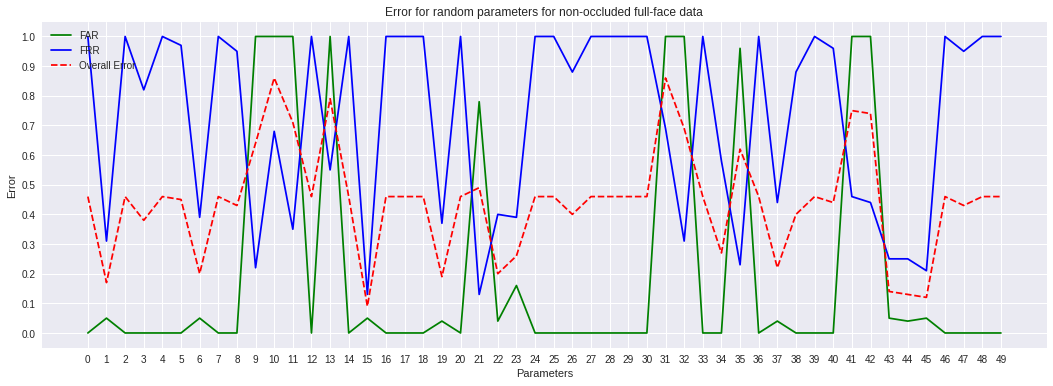

In [ ]:
#random search
count = 50
result = random_search(val_images, val_labels, count)
plt.xlabel("Parameters")
plt.ylabel("Error")
plt.title("Error for random parameters for non-occluded full-face data")
plt.xticks(range(0,count))
plt.yticks(np.arange(0,1.1,0.1))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(range(0,count), result.FAR, color='green', label='FAR')
plt.plot(range(0,count), result.FRR, color='blue', label='FRR')
plt.plot(range(0,count), result.OE, color='red', linestyle='--', label='Overall Error')
plt.legend()
plt.savefig('./results/Random Search for Non-Occluded Full-Face Data.png')

In [ ]:
result.loc[15]

params    r:8, n:11, x:2, y:7, t:23
FAR                            0.05
FRR                            0.13
OE                             0.09
Name: 15, dtype: object

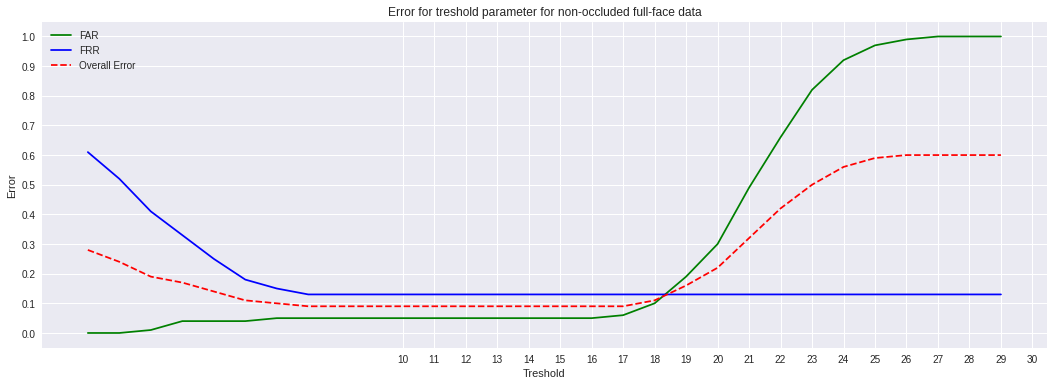

In [ ]:
#threshold search
r = range(10,40)
#t_result = threshold_search(val_images, val_labels, r, [8,11,2,7])
plt.xlabel("Treshold")
plt.ylabel("Error")
plt.title("Error for treshold parameter for non-occluded full-face data")
plt.xticks(r)
plt.yticks(np.arange(0,1.1,0.1))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(range(0,30), t_result.FAR, color='green', label='FAR')
plt.plot(range(0,30), t_result.FRR, color='blue', label='FRR')
plt.plot(range(0,30), t_result.OE, color='red', linestyle='--', label='Overall Error')
plt.legend()
plt.savefig('./results/Threshold Search for Non-Occluded Full-Face Data params.png')

In [ ]:
t_result.loc[18]

value    28.00
FAR       0.10
FRR       0.13
OE        0.11
Name: 18, dtype: float64

In [ ]:
FAR, FRR, OE = eval(test_images, test_labels, 8, 11, 2, 7, 28)
print("FAR: {}, FRR: {}, OE: {}".format(FAR, FRR, OE))

FAR: 0.12, FRR: 0.15, OE: 0.14


##Occluded Images

In [9]:
def create_occlusion(img):
  (h, w) = img.shape[:2]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, rect = get_face(img)
  landmarks = landmark_detector(gray, rect)
  points = landmarks.parts()

  eyeglasses = img.copy()
  mask = img.copy()

  #scale the rectangle around landmarks so it will occlude desired parts
  cv2.rectangle(eyeglasses, (0, int(points[37].y - 0.05*h)), (w, int(points[46].y + 0.055*h)), (128,128,128), -1  ) 
  cv2.rectangle(mask, (0, int(points[39].y+ 0.02*h)),  (w, int(points[57].y + 0.05*h)), (128,128,128), -1)
  
  return np.array([cv2.cvtColor(mask[rect.top():rect.bottom(), rect.left():rect.right()], cv2.COLOR_BGR2GRAY), cv2.cvtColor(eyeglasses[rect.top():rect.bottom(), rect.left():rect.right()], cv2.COLOR_BGR2GRAY)])
  #returns the single channel (grayscale) image since it will be used like this in test phase.

In [10]:
def get_occluded_partition(df, partition):
  df = np.array([[create_occlusion(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))[0],create_occlusion(cv2.imread("./data/full_faces/non_occluded/images/"+row.file))[1], row.identity, row.identity] for i, row in df[df.partition == partition].iterrows()]).T
  return np.concatenate((df[0], df[1]), axis=0) , np.concatenate((df[2], df[3]), axis=0)

In [11]:
occ_val_images, occ_val_labels = get_occluded_partition(data, "validation")

occ_test_images, occ_test_labels = get_occluded_partition(data, "test")

IntProgress(value=0, max=50)

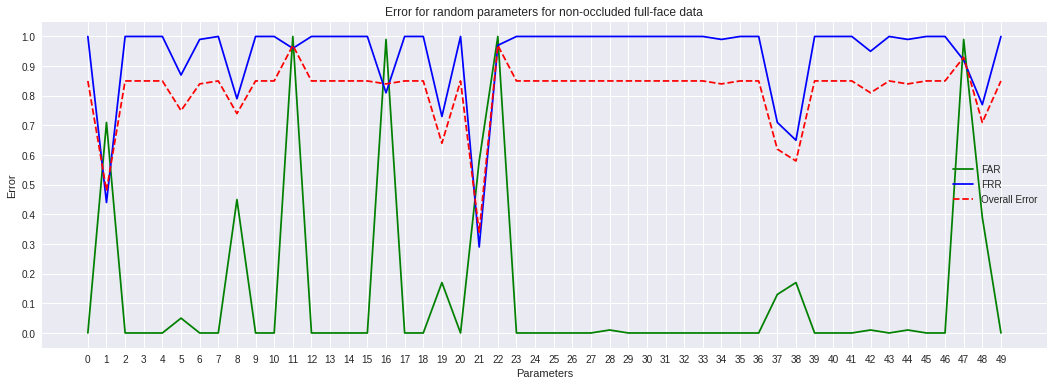

In [15]:
#random search
count = 50
result = random_search(occ_val_images, occ_val_labels, count)
plt.xlabel("Parameters")
plt.ylabel("Error")
plt.title("Error for random parameters for non-occluded full-face data")
plt.xticks(range(0,count))
plt.yticks(np.arange(0,1.1,0.1))
plt.rcParams['figure.figsize'] = (18,6)
plt.plot(range(0,count), result.FAR, color='green', label='FAR')
plt.plot(range(0,count), result.FRR, color='blue', label='FRR')
plt.plot(range(0,count), result.OE, color='red', linestyle='--', label='Overall Error')
plt.legend()
#plt.savefig('./results/Random Search for Occluded Full-Face Data.png')

In [30]:
result_df = eval(occ_val_images, occ_val_labels, 13, 7, 14, 1, 28)

In [32]:
#mask error
result_df[(result_df.error == 1) & (result_df.occ_type == "mask")].shape[0] / result_df[result_df.occ_type == "mask"].shape[0]

0.4805194805194805

In [35]:
#eyeglasses error
result_df[(result_df.error == 1) & (result_df.occ_type == "eyeglasses")].shape[0] / result_df[result_df.occ_type == "eyeglasses"].shape[0]

0.4772727272727273